In [41]:
%load_ext autoreload
%autoreload 2
import os
os.environ['TRANSFORMERS_CACHE'] = "/media/data/flowers/OpenELM/models"
from transformers import AutoModel, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import numpy as np
import json 
from openelm.environments.p3 import skill_list
import pickle
from tqdm import tqdm
from langchain.schema import HumanMessage

model_id= "Salesforce/codet5p-110m-embedding"
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
model = AutoModel.from_pretrained(model_id, trust_remote_code=True,device_map="auto")

def getallitems(maps):
    """
    Returns all the phenotypes that are in the Map."""
    genomes = maps["genomes"]
    valid_phenotype=[]
    for gen in np.ndindex(genomes.shape):
        value_gen = type(genomes[gen])
        if value_gen!=float and value_gen!=int:
            valid_phenotype.append(genomes[gen])

    return valid_phenotype

# init maps
def getallitems(maps):
    """
    Returns all the phenotypes that are in the Map."""
    genomes = maps["genomes"]
    valid_phenotype=[]
    for gen in np.ndindex(genomes.shape):
        value_gen = type(genomes[gen])
        if value_gen!=float and value_gen!=int:
            valid_phenotype.append(genomes[gen])

    return valid_phenotype

# init maps
def return_cells_filled_per_gen_map_elite(path_save_all,max_gen=-1,include_trainset=False,include_full_trainset=False):
    #_init_discretization():
    behavior_space= np.repeat([[0, 1]], 10, axis=0).T

    bins = np.linspace(*behavior_space,  3)[1:-1].T  # type: ignore
    # bins
    def to_mapindex(b, bins=bins) :
        """Converts a phenotype (position in behaviour space) to a map index."""
        return (
            None
            if b is None
            else tuple(np.digitize(x, bins) for x, bins in zip(b, bins))
        )
        

    path_maps = path_save_all.split("save_all.json")[0]+"maps.pkl"

    with open(path_maps, "rb") as f:
        maps = pickle.load(f)
    allitems=getallitems(maps)
    items_trainset = [item for item in allitems if item.idx_generation==-1]
    items_gen = [item for item in allitems if item.idx_generation!=-1]
    print(len(items_trainset), len(items_gen))
    len(items_trainset), len(items_gen)
    nonzero=np.zeros_like(maps["nonzero"]) 
    list_map_ix_train=[to_mapindex(puzz.emb) for puzz in items_trainset]
    if include_full_trainset:
        path_trainset = "/media/data/flowers/OpenELM/src/openelm/utils/preprocess_p3_emb.json"
        with open(path_trainset, "r") as f:
            list_puzzle_full_trainset = json.load(f)
            list_map_ix_train=[to_mapindex(puzz["emb"]) for puzz in list_puzzle_full_trainset]
            for map_ix_train in list_map_ix_train:
                nonzero[map_ix_train] = True
    elif include_trainset:
        for map_ix_train in list_map_ix_train:
            nonzero[map_ix_train] = True

    # separate items per generation
    list_gens= [puzz.idx_generation for puzz in items_gen]
    if max_gen==-1:
        max_gen = max(list_gens)
    
    list_emb_per_idx_gen = [[] for _ in range(max_gen+1)]
    for i, gen in enumerate(list_gens):
        if gen<len(list_emb_per_idx_gen):
            list_emb_per_idx_gen[gen].append(items_gen[i].emb)
        
    number_of_cells_filled=[nonzero.sum()]
    for i in range(len(list_emb_per_idx_gen)):
        for puzz_emb in list_emb_per_idx_gen[i]:
            new_map_ix=to_mapindex(puzz_emb)
            nonzero[new_map_ix] = True
        number_of_cells_filled.append(nonzero.sum())
    return number_of_cells_filled



def return_cells_filled_in_embspace_from_NLPembspace(path_save_all,path_centroids,max_gen=-1,include_trainset=False,include_full_trainset=False,model=model,tokenizer=tokenizer):
    #_init_discretization():
    centroids=np.load(path_centroids)
    # bins
    def to_mapindex(b,centroids=centroids):
        """Maps a phenotype (position in behaviour space) to the index of the closest centroid."""
        return (
            None
            if b is None
            else (np.argmin(np.linalg.norm(b - centroids, axis=1)),)
        )
        
    path_maps_cvt = path_centroids.split("centroids.npy")[0]+"maps.pkl"
    path_maps = path_save_all.split("save_all.json")[0]+"maps.pkl"

    with open(path_maps_cvt, "rb") as f:
        maps_cvt = pickle.load(f)
    with open(path_maps, "rb") as f:
        maps = pickle.load(f)
    allitems=getallitems(maps)
    with torch.no_grad():
        for i in tqdm(range(len(allitems))):
            program_str=allitems[i].program_str
            inputs = tokenizer.encode(program_str, return_tensors="pt",truncation=True,max_length=512)
            emb = model(inputs.to("cuda"))[0]
            allitems[i].emb=emb.to("cpu").numpy()

    items_trainset = [item for item in allitems if item.idx_generation==-1]
    items_gen = [item for item in allitems if item.idx_generation!=-1]
    print(len(items_trainset), len(items_gen))
    len(items_trainset), len(items_gen)
    
    nonzero=np.zeros_like(maps_cvt["nonzero"]) 
    list_map_ix_train=[to_mapindex(puzz.emb) for puzz in items_trainset]
    
    if include_full_trainset:
        path_trainset = "/media/data/flowers/OpenELM/src/openelm/utils/preprocess_p3_emb.json"
        with open(path_trainset, "r") as f:
            list_puzzle_full_trainset = json.load(f)
            # list_puzzle_full_trainset["program_str"]
        with torch.no_grad():
            for i in tqdm(range(len(list_puzzle_full_trainset))):
                program_str=list_puzzle_full_trainset[i]["program_str"]
                inputs = tokenizer.encode(program_str, return_tensors="pt",truncation=True,max_length=512)
                emb = model(inputs.to("cuda"))[0]
                list_puzzle_full_trainset[i]["emb"]=emb.to("cpu").numpy()
        list_map_ix_train=[to_mapindex(puzz["emb"]) for puzz in list_puzzle_full_trainset]
        for map_ix_train in list_map_ix_train:
            nonzero[map_ix_train] = True
              
    elif include_trainset:
        for map_ix_train in list_map_ix_train:
            nonzero[map_ix_train] = True

    # separate items per generation
    list_gens= [puzz.idx_generation for puzz in items_gen]
    if max_gen==-1:
        max_gen = max(list_gens)
    
    list_emb_per_idx_gen = [[] for _ in range(max_gen+1)]
    for i, gen in enumerate(list_gens):
        if gen<len(list_emb_per_idx_gen):
            list_emb_per_idx_gen[gen].append(items_gen[i].emb)
        
    number_of_cells_filled=[nonzero.sum()]
    for i in range(len(list_emb_per_idx_gen)):
        for puzz_emb in list_emb_per_idx_gen[i]:
            new_map_ix=to_mapindex(puzz_emb)
            nonzero[new_map_ix] = True
        number_of_cells_filled.append(nonzero.sum())
    return number_of_cells_filled



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path_centroids= "/media/data/flowers/OpenELM/logs/elm/23-08-26_21:19/step_5/centroids.npy"

path_save_all="/media/data/flowers/OpenELM/logs/elm/23-08-26_21:42/step_1/save_all.json"
path_maps = path_save_all.split("save_all.json")[0]+"maps.pkl"
# with open(path_save_all, "r") as f:
#     list_puzz = json.load(f)
with open(path_maps, "rb") as f:
    maps = pickle.load(f)
allitems=getallitems(maps)
items_trainset = [item for item in allitems if item.idx_generation==-1]
items_gen = [item for item in allitems if item.idx_generation!=-1]
len(items_trainset), len(items_gen)


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /media/data/flowers/conda/envs/codegpt/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA SETUP: CUDA runtime path found: /media/data/flowers/conda/envs/codegpt/lib/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /media/data/flowers/conda/envs/codegpt/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


(536, 9)

In [3]:
# 67=308
price_b0=8 # random
price_b1=8 # ELM
price_b2=10.5 # ELM + NLP space
price_b3= 16 # dumb IMGEP
price_b4 = 16 # smart IMGEP
n_expe=4
ratio=400/300
(price_b0+price_b1+price_b2+price_b3+price_b4)*n_expe*ratio

312.0

## NLP space

319 1258
346 1733
381 2015
405 1896


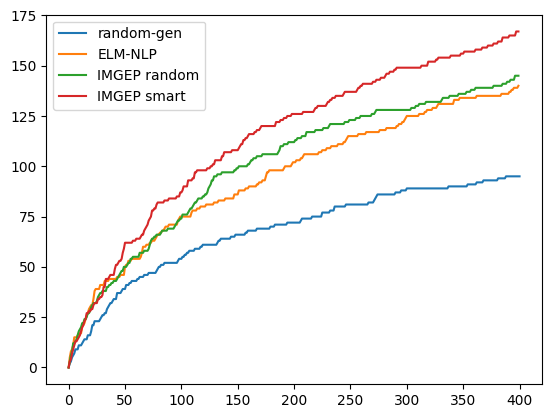

In [5]:
include_trainset=False
# IMGEP smart
# seed = 42
# expe 1 
imgep_smart = "/media/data/flowers/OpenELM/logs/elm/23-08-26_15:17/step_399/save_all.json"# 20 #"/media/data/flowers/OpenELM/logs/elm/23-08-25_11:24/step_299/save_all.json" # 15$

# imgep random
# expe 1
imgep_random ="/media/data/flowers/OpenELM/logs/elm/23-08-26_17:12/step_399/save_all.json"# 20$ "/media/data/flowers/OpenELM/logs/elm/23-08-25_19:57/step_299/save_all.json" # 15$
# ELM-NLP
elm_NLP ="/media/data/flowers/OpenELM/logs/elm/23-08-26_18:51/step_399/save_all.json"# 20$"/media/data/flowers/OpenELM/logs/elm/23-08-26_01:02/step_299/save_all.json" # 10.50$
# ELM-base
elm_base="" # start at 65.48$
# Random gen 
rd_gen = "/media/data/flowers/OpenELM/logs/elm/23-08-26_11:55/step_399" # 10.24$ for 400 start at 41.08 to 51,32
rd_gen+= "/save_all.json"

#plo
number_of_cells_filled_b0=return_cells_filled_per_gen_map_elite(rd_gen,include_trainset=include_trainset)#,max_gen=300)

number_of_cells_filled_b2=return_cells_filled_per_gen_map_elite(elm_NLP,include_trainset=include_trainset)#,max_gen=300)
idx_m=-1#len(number_of_cells_filled_b2)+100
number_of_cells_filled_b3=return_cells_filled_per_gen_map_elite(imgep_random,include_trainset=include_trainset)#,max_gen=300)
number_of_cells_filled_b4=return_cells_filled_per_gen_map_elite(imgep_smart,include_trainset=include_trainset)#,max_gen=300)
plt.plot(number_of_cells_filled_b0)
plt.plot(number_of_cells_filled_b2[:idx_m])
plt.plot(number_of_cells_filled_b3[:idx_m])
plt.plot(number_of_cells_filled_b4[:idx_m])
plt.legend(["random-gen","ELM-NLP","IMGEP random", "IMGEP smart"])

319 1258
346 1733
381 2015
405 1896


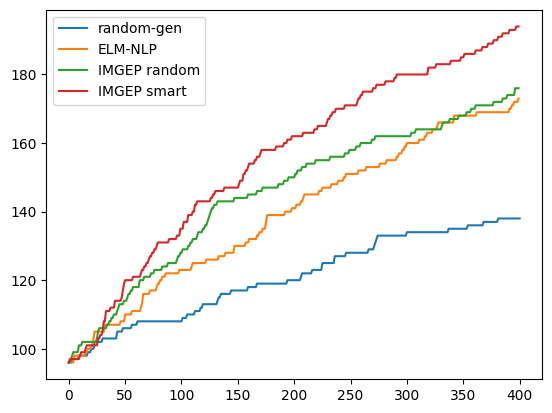

In [42]:
include_trainset=True

number_of_cells_filled_b0=return_cells_filled_per_gen_map_elite(rd_gen,include_full_trainset=include_trainset)#,max_gen=300)

number_of_cells_filled_b2=return_cells_filled_per_gen_map_elite(elm_NLP,include_full_trainset=include_trainset)#,max_gen=300)
idx_m=-1#len(number_of_cells_filled_b2)+100
number_of_cells_filled_b3=return_cells_filled_per_gen_map_elite(imgep_random,include_full_trainset=include_trainset)#,max_gen=300)
number_of_cells_filled_b4=return_cells_filled_per_gen_map_elite(imgep_smart,include_full_trainset=include_trainset)#,max_gen=300)
plt.plot(number_of_cells_filled_b0)
plt.plot(number_of_cells_filled_b2[:idx_m])
plt.plot(number_of_cells_filled_b3[:idx_m])
plt.plot(number_of_cells_filled_b4[:idx_m])
plt.ylabel("Number of niches filled")
plt.xlabel("Number of generation")
plt.legend(["random-gen","ELM-NLP","IMGEP random", "IMGEP smart"])

## emb space

In [16]:
path_centroids= "/media/data/flowers/OpenELM/logs/elm/23-08-27_14:15/step_399/centroids.npy"
elm="/media/data/flowers/OpenELM/logs/elm/23-08-27_14:15/step_399/"

100%|██████████| 1577/1577 [00:13<00:00, 119.11it/s]


319 1258


100%|██████████| 3028/3028 [00:26<00:00, 114.40it/s]


532 2496


100%|██████████| 2079/2079 [00:20<00:00, 101.96it/s]


346 1733


100%|██████████| 2396/2396 [00:30<00:00, 78.19it/s]


381 2015


100%|██████████| 2301/2301 [00:30<00:00, 75.46it/s]


405 1896


100%|██████████| 536/536 [00:06<00:00, 89.05it/s] 


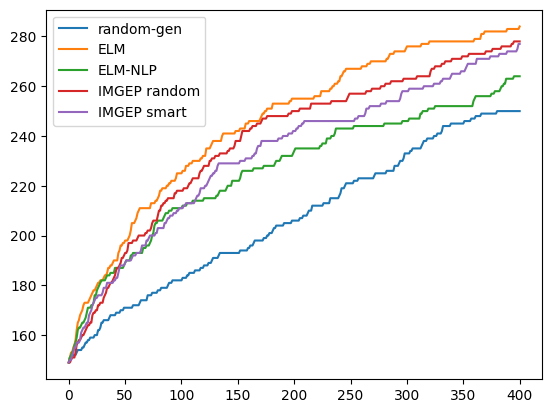

In [37]:
include_full_trainset=True
number_of_cvt_cells_filled_b0=return_cells_filled_in_embspace_from_NLPembspace(rd_gen,path_centroids,include_full_trainset=include_full_trainset)
number_of_cvt_cells_filled_b1=return_cells_filled_in_embspace_from_NLPembspace(elm,path_centroids,include_full_trainset=include_full_trainset)
number_of_cvt_cells_filled_b2=return_cells_filled_in_embspace_from_NLPembspace(elm_NLP,path_centroids,include_full_trainset=include_full_trainset)
number_of_cvt_cells_filled_b3=return_cells_filled_in_embspace_from_NLPembspace(imgep_random,path_centroids,include_full_trainset=include_full_trainset)
number_of_cvt_cells_filled_b4=return_cells_filled_in_embspace_from_NLPembspace(imgep_smart,path_centroids,include_full_trainset=include_full_trainset)

plt.plot(number_of_cvt_cells_filled_b0)
plt.plot(number_of_cvt_cells_filled_b1)
plt.plot(number_of_cvt_cells_filled_b2)
plt.plot(number_of_cvt_cells_filled_b3)
plt.plot(number_of_cvt_cells_filled_b4)
plt.ylabel("Number of niches filled")
plt.xlabel("Number of generation")
plt.legend(["random-gen","ELM","ELM-NLP","IMGEP random", "IMGEP smart"])